In [1]:
import pandas as pd
from itertools import cycle
import gpflow
import numpy as np
from gpflow.utilities import print_summary, positive
from gpflow.ci_utils import ci_niter
from gpflow.optimizers import NaturalGradient
from gpflow import set_trainable
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from collections import namedtuple
import statsmodels.api as sm

sns.set(style="white")
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

gpflow.config.set_default_float(np.float64)
gpflow.config.set_default_summary_fmt("notebook")

/Users/leo/opt/anaconda3/envs/covid/lib/python3.6/site-packages/ipykernel_launcher.py:21: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


# Dataset

## Mobility

In [2]:
mobility_data = pd.read_csv(
    "./Data/Google/Global_Mobility_Report.csv", 
    encoding="ISO-8859-1", 
    parse_dates=["date"],
    dayfirst=True
)
mobility_data_us = mobility_data[
    (mobility_data["country_region"]=="United States") & 
    (~mobility_data["sub_region_1"].isnull()) &
    (mobility_data["sub_region_2"].isnull())
]
mobility_data_us_temp = mobility_data_us.iloc[:,7:] # keep only relevant columns
mobility_data_us_temp["state"] = mobility_data_us["sub_region_1"]
mobility_data_us_temp.iloc[:,1:-1] = mobility_data_us_temp.iloc[:,1:-1].apply(lambda x: x/100 + 1)
mobility_data_us =  mobility_data_us_temp.reset_index(drop=True)
mobility_data_us = pd.DataFrame({
    "state": mobility_data_us["state"],
    "date": mobility_data_us["date"],
    "HOME": mobility_data_us['residential_percent_change_from_baseline'],
    "WORK": mobility_data_us['workplaces_percent_change_from_baseline'],
    "RECREATIONAL": mobility_data_us['retail_and_recreation_percent_change_from_baseline'],
    "OTHER": mobility_data_us.iloc[:,2:5].mean(axis=1)
})

processed_dfs = []

for state in mobility_data_us["state"].unique():
    d = mobility_data_us[mobility_data_us["state"] == state].copy()
    
    d["HOME"] = d["HOME"].rolling(7).median()
    d["WORK"] = d["WORK"].rolling(7).median()
    d["RECREATIONAL"] = d["RECREATIONAL"].rolling(7).median()
    d["OTHER"] = d["OTHER"].rolling(7).median()

    processed_dfs.append(d)
    
mobility_data_us = pd.concat(processed_dfs)

/Users/leo/opt/anaconda3/envs/covid/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (4) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Cases

In [3]:
# COVID Cases from Microsoft, includes Recovered and Infected
ms_covid = pd.read_csv(
    "./Data/Microsoft/COVID_CASES.csv", 
    encoding="ISO-8859-1",
    parse_dates=["Updated"],
    dayfirst=False
)
ms_us_covid = ms_covid[
    (ms_covid["Country_Region"]=="United States") & 
    (~ms_covid["AdminRegion1"].isnull()) &
    (ms_covid["AdminRegion2"].isnull())
]
ms_us_covid = ms_us_covid.loc[:,["AdminRegion1", "Updated", "Confirmed", "ConfirmedChange", "Deaths", "Recovered"]]
ms_us_covid.rename(columns={"AdminRegion1": "state"}, inplace=True)
ms_us_covid.reset_index(drop=True, inplace=True)
population = pd.read_excel(
    "./Data/Population/US_population_raw_data.xls",
)
STATE_POPULATION = dict(zip(population[1:].Location, population[1:].COVIDTotal))

processed_dfs = []

for state in ms_us_covid["state"].unique():
    d = ms_us_covid[ms_us_covid["state"] == state]
    d = d.fillna(method='ffill').fillna(0)
    d["I"] = d["Confirmed"] - d["Deaths"] - d["Recovered"]

    d["S"] = int(STATE_POPULATION[state]) - d["I"]

    d["ConfirmedChange"] = np.log(d["ConfirmedChange"].rolling(7).median()+1)
    d["I"] = np.log(d["I"].rolling(7).median()+1)
    d["S"] = np.log(d["S"].rolling(7).median()+1)

    d.dropna(inplace=True)
    processed_dfs.append(d)
    
ms_us_covid = pd.concat(processed_dfs)
ms_us_covid["WEEKDAY"] = (ms_us_covid["Updated"].dt.dayofweek < 5).astype(int)
ms_us_covid["index"] = ms_us_covid["Updated"].dt.dayofyear

## Merge

In [4]:
final_data = ms_us_covid.merge(
    mobility_data_us, how='left', left_on=["state", "Updated"], right_on=["state", "date"]
)
final_data.dropna(inplace=True)
final_data.set_index("state", inplace=True)

# Model

In [5]:
from model import COVIDGPModel

In [6]:
def run_for_state(name, data):
    t = data[["Updated"]]
    y = data[["ConfirmedChange"]]
    X = pd.DataFrame({
        "index": data["index"],
        "S": data["S"],
        "I": data["I"],
        "HOME": data["HOME"],
        "WORK": data["WORK"],
        "RECREATIONAL": data["RECREATIONAL"],
    }, index=data.index)[[
        "index",
        "S",
        "I",
        "HOME", 
        "WORK", 
        "RECREATIONAL"
    ]]

    model_params = {
        'kernel': (
            gpflow.kernels.SquaredExponential(lengthscales=np.ones(X.shape[1])) +
            gpflow.kernels.Linear() +
            gpflow.kernels.RationalQuadratic(lengthscales=np.ones(X.shape[1]))
        )
    }

    y_scaler = preprocessing.StandardScaler().fit(y)
    y_train = y_scaler.transform(y)

    x_scaler = preprocessing.StandardScaler().fit(X)
    X_train = x_scaler.transform(X)

    model = COVIDGPModel(name, **model_params)
    model.train(X_train, y_train)

    mean_train, var_train = model.predict(X_train)
    y_train_pred = y_scaler.inverse_transform(mean_train.numpy())
    y_train_true = y_scaler.inverse_transform(y_train)

    res = y_train_true - y_train_pred
    
    return model, res

In [7]:
results_states = {}
for state in final_data.index.unique():
    data = final_data.loc[state]
    results_states[state] = run_for_state(state, data)

In [8]:
results_states.keys()

dict_keys(['Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California', 'Colorado', 'Connecticut', 'District of Columbia', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Iowa', 'Idaho', 'Illinois', 'Indiana', 'Kansas'])

In [21]:
import dill as pickle
pickle.dump(results_states, open('tmp/trained_models_states.pkl', 'wb'))

## White noise

In [11]:
dates = pd.date_range(final_data[["Updated"]].min().values[0], final_data[["Updated"]].max().values[0]).values
u0 = np.random.normal(size=len(dates))

u0 = pd.DataFrame({"Updated": dates, "Residual": u0})
u0.head()

,Updated,Residual
0,2020-02-21,-0.509213
1,2020-02-22,0.703437
2,2020-02-23,0.310949
3,2020-02-24,0.216742
4,2020-02-25,1.531984


<AxesSubplot:>

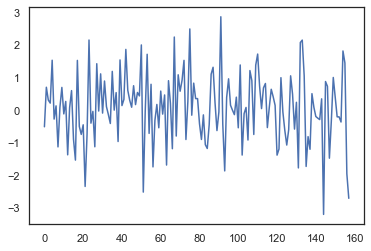

In [12]:
u0["Residual"].plot()

## $h_.(t)$ linear filters

In [53]:
from functools import partial

In [201]:
linear_filters_states = {}
for state in results_states.keys():
    u0_ = u0[u0['Updated'].isin(final_data.loc[state, 'Updated'])]
    state_residual = results_states[state][1]
    h_vals = state_residual / u0_['Residual'].values.reshape(-1, 1)
    t = u0_["Updated"].index.astype('float').values.reshape(-1, 1)
    
    def _yule_walker(X, coeff_=None, sigma_=None):
        order = len(coeff_)
        X_lag = X[-order:,:]
        return tf.square(sigma_) + tf.tensordot(X_lag.T, np.array(coeff_), axes=1)
    
    rho_, sigma_ = sm.regression.yule_walker(h_vals, order=28, method="mle")
    linear_filters_states[state] = partial(_yule_walker, coeff_=tuple(rho_), sigma_=sigma_)

In [202]:
pickle.dump(linear_filters_states, open('tmp/linear_filters_states.pkl', 'wb'))

In [203]:
linear_filters_states.keys()

dict_keys(['Alaska', 'Alabama', 'Arkansas', 'Arizona', 'California', 'Colorado', 'Connecticut', 'District of Columbia', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Iowa', 'Idaho', 'Illinois', 'Indiana', 'Kansas'])

# GPFlow`

In [204]:
p = {s: (results_states[s][0], linear_filters_states[s]) for s in results_states.keys()}

In [208]:
class ManualConvolutionMultiOutput(gpflow.kernels.Kernel):
    def __init__(self, p, order=28):
        super().__init__()
        self.p = p
        self.order = order

    @staticmethod
    def cov(X, t, h_X, Y, s, h_Y, order, T):
        return tf.sum([
            h_X(X[:i,:]) * h_Y(Y[:i+s-t,:]) 
            for i in range(order, T)
        ], axis=0)
        
    def K(self, X, X2=None):
        if X2 is None:
            X2 = X
        
        T = X.shape[0]
        N = len(self.p)
        
        X_states = dict(zip(self.p.keys(), tf.split(X, num_or_size_splits=N, axis=1)))
        X2_states = dict(zip(self.p.keys(), tf.split(X2, num_or_size_splits=N, axis=1)))
        
        k = np.zeros((T*N,)*2)
        
        ## TODO: optimise this monster....
        for s_i, state_X in enumerate(self.keys()):
            for s_j, state_Y in enumerate(self.keys()):
                k_X = self.p[state_X][0].kernel.K(X_states[state_X], X2_states[state_Y])
                for t_i in range(T):
                    for t_j in range(T):
                        k[s_i*T+t_i, s_j*T+t_j] = k_X[t_i, t_j] + self.cov(
                            X_states[state_X], t_i, self.p[state_X][1],
                            X2_states[state_Y], t_j, self.p[state_Y][1],
                            self.order, T
                        )
            
        
        return k

    def K_diag(self, X):
        return tf.linalg.diag_part(self.K(X))


k_custom = ManualConvolutionMultiOutput(p)